# Проектная работа
## Анализ датасета '12housing'
Maria Minkova

In [702]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.iolib.summary2 import summary_params
from scipy.stats import t
from scipy.stats import f # F-распределение
from statsmodels.iolib.summary2 import summary_col # вывод подгонки
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import patsy # матрицы регрессионного дизайна
import scipy.stats as stats
import statsmodels.stats.api as sms # тесты
from scipy.stats import chi2 # 𝜒2-распределение

###  Загрузим данные

In [703]:
df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/12Housing.csv')
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


###   Обработка данных

In [704]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


Nan-ов нет

Вернем нормальную индексацию

In [705]:
df['mainroad'].unique()

array(['yes', 'no'], dtype=object)

In [706]:
df['guestroom'].unique()

array(['no', 'yes'], dtype=object)

In [707]:
df['basement'].unique()

array(['no', 'yes'], dtype=object)

In [708]:
df['hotwaterheating'].unique()

array(['no', 'yes'], dtype=object)

In [709]:
df['airconditioning'].unique()

array(['yes', 'no'], dtype=object)

In [710]:
df['prefarea'].unique()

array(['yes', 'no'], dtype=object)

In [711]:
df['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

Заменим бианрные признаки на 1, 0

In [712]:
cleanup_nums = {"mainroad": {'yes': 1, 'no': 0},
               "guestroom": {'yes': 1, 'no': 0},
               "basement": {'yes': 1, 'no': 0},
               "hotwaterheating": {'yes': 1, 'no': 0},
               "airconditioning": {'yes': 1, 'no': 0},
               "prefarea": {'yes': 1, 'no': 0}}
df = df.replace(cleanup_nums)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


Теперь закодируем категориальные признаки

In [713]:
area_dummies = pd.get_dummies(df.furnishingstatus)
df = pd.concat([df, area_dummies], axis=1)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,furnished,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,1,0,0


In [714]:
df = df.rename(columns={"semi-furnished":'semi'})
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,furnished,semi,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,1,0,0


Данные готовы к исследованию!

###  Визуализация данных

**Числовые признаки**

<Axes: xlabel='price', ylabel='Count'>

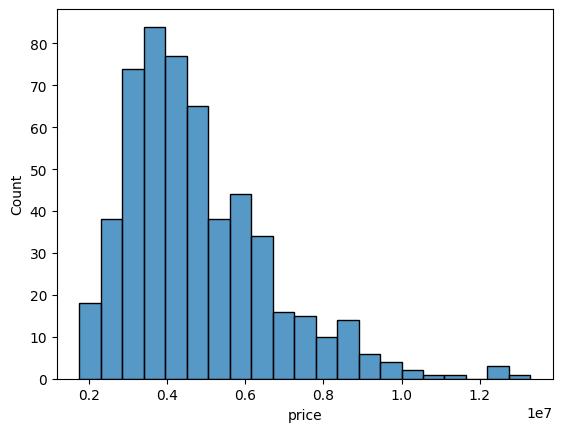

In [715]:
sns.histplot(data=df, x='price')

<Axes: xlabel='area', ylabel='Count'>

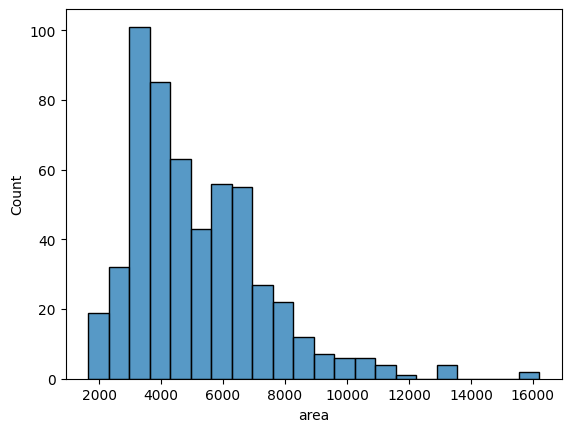

In [716]:
sns.histplot(data=df, x='area')

<Axes: xlabel='bedrooms', ylabel='Count'>

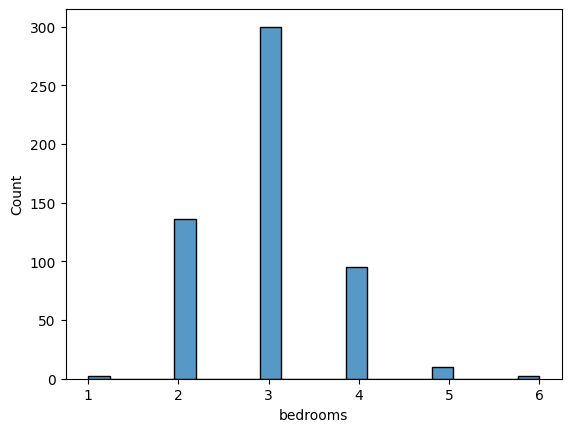

In [717]:
sns.histplot(data=df, x='bedrooms')

<Axes: xlabel='bathrooms', ylabel='Count'>

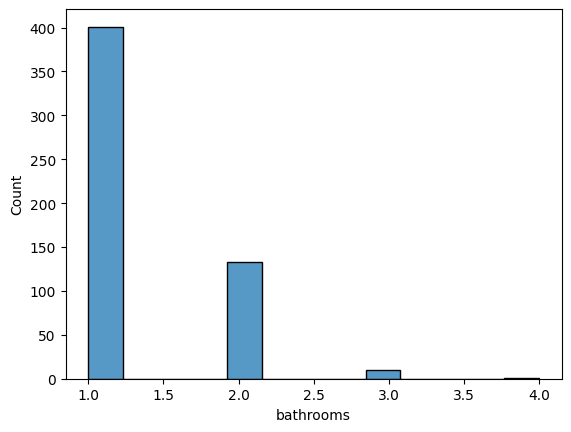

In [718]:
sns.histplot(data=df, x='bathrooms')

<Axes: xlabel='stories', ylabel='Count'>

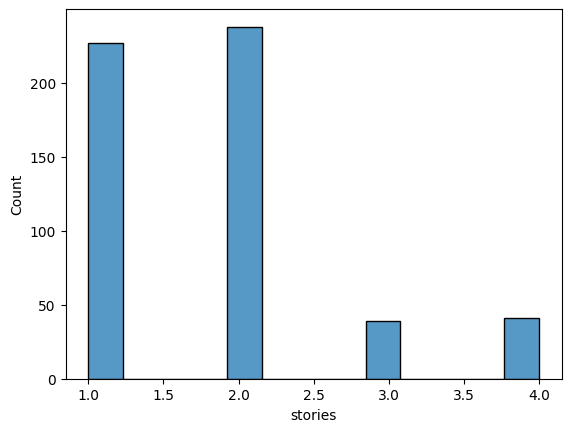

In [719]:
sns.histplot(data=df, x='stories')

<Axes: xlabel='parking', ylabel='Count'>

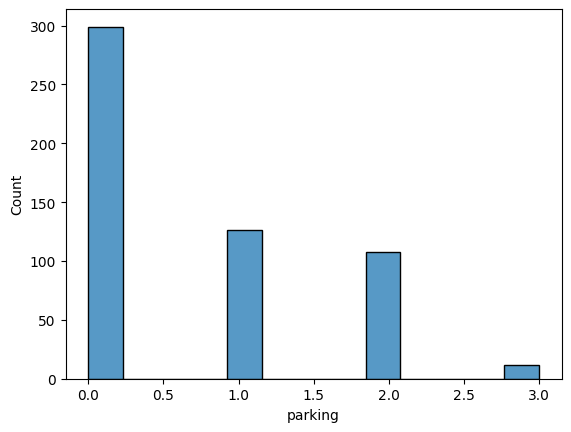

In [720]:
sns.histplot(data=df, x='parking')

**Вывод:**
1) bedrooms и price близки к нормальному распределению
2) у остальных признаков преобладают маленькие значения

**Визуализация категориальных признаков**

<Axes: xlabel='mainroad', ylabel='count'>

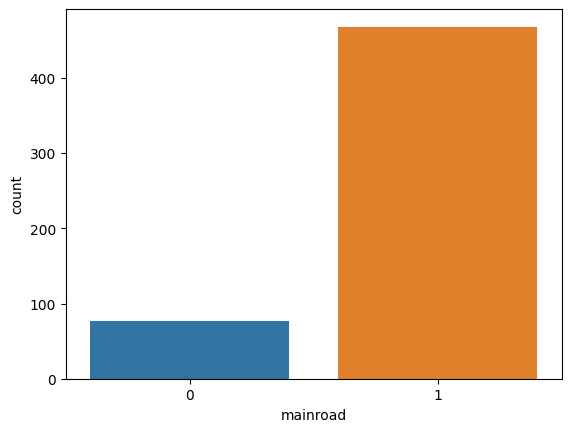

In [722]:
sns.countplot(data=df, x='mainroad')

**Вывод:** виден явный дизбаланс

<Axes: xlabel='guestroom', ylabel='count'>

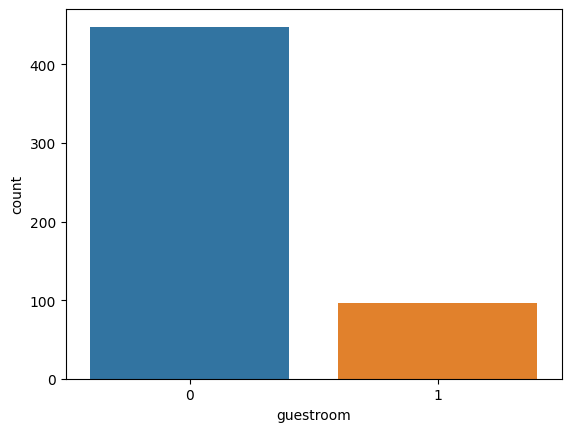

In [723]:
sns.countplot(data=df, x='guestroom')

**Вывод:** явный дизбаланс

<Axes: xlabel='basement', ylabel='count'>

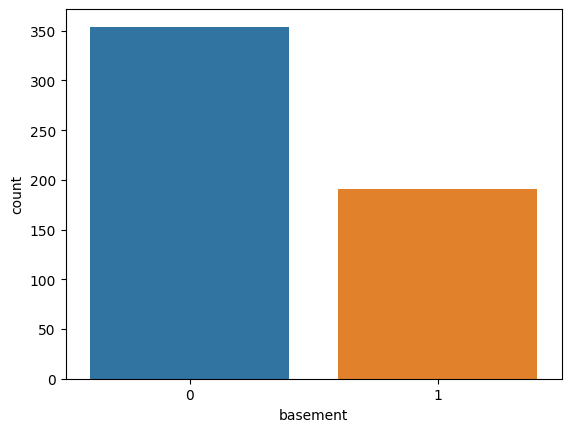

In [724]:
sns.countplot(data=df, x='basement')

**Вывод:** небольшой дизбаланс

<Axes: xlabel='hotwaterheating', ylabel='count'>

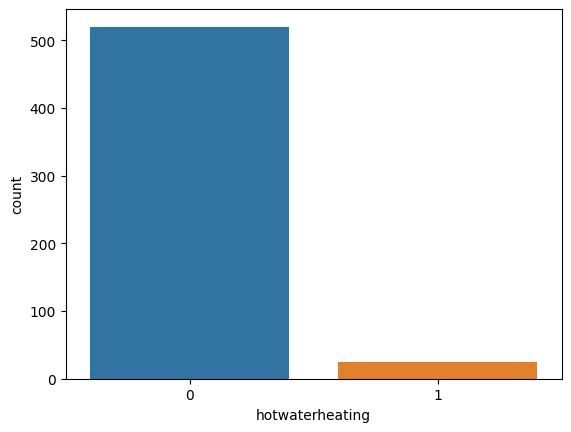

In [725]:
sns.countplot(data=df, x='hotwaterheating')

**Вывод:** явный дизбаланс

<Axes: xlabel='airconditioning', ylabel='count'>

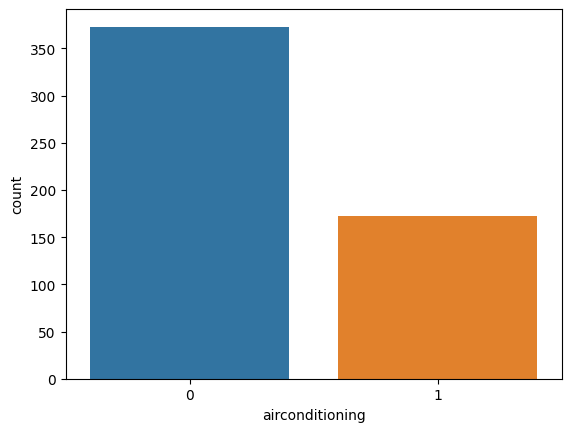

In [726]:
sns.countplot(data=df, x='airconditioning')

**Вывод:** небольшой дизбаланс

<Axes: xlabel='prefarea', ylabel='count'>

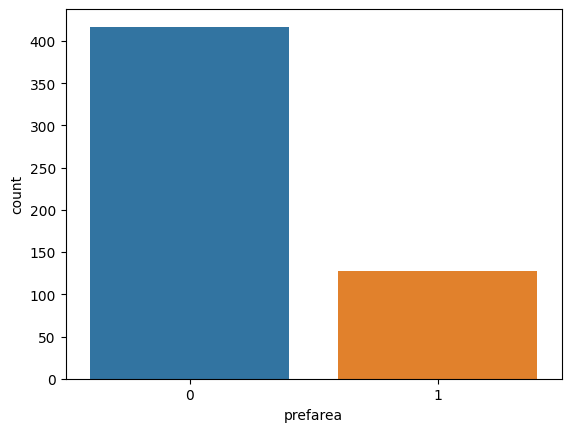

In [727]:
sns.countplot(data=df, x='prefarea')

**Вывод:** явный дизбаланс

**Построим несколько графиков**

<Axes: xlabel='area', ylabel='price'>

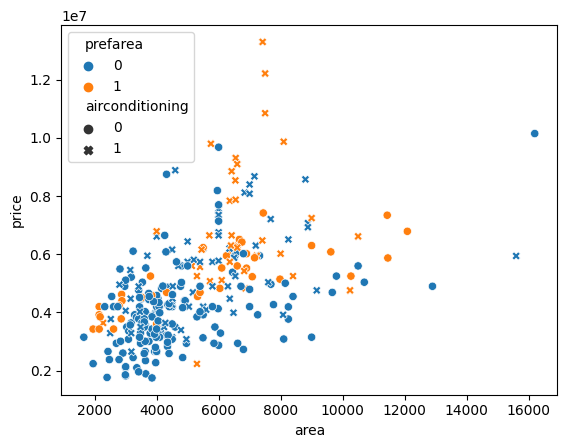

In [728]:
sns.scatterplot(data=df.sample(300), x='area', y='price', style='airconditioning', hue='prefarea')

<Axes: xlabel='area', ylabel='price'>

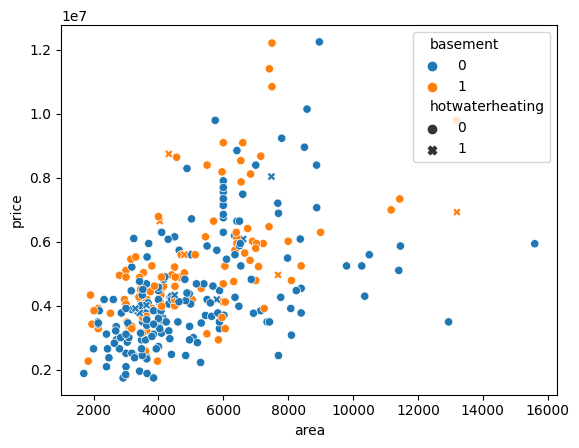

In [729]:
sns.scatterplot(data=df.sample(300), x='area', y='price', style='hotwaterheating', hue='basement')

**Диаграммы рассеения**

<Axes: xlabel='area', ylabel='price'>

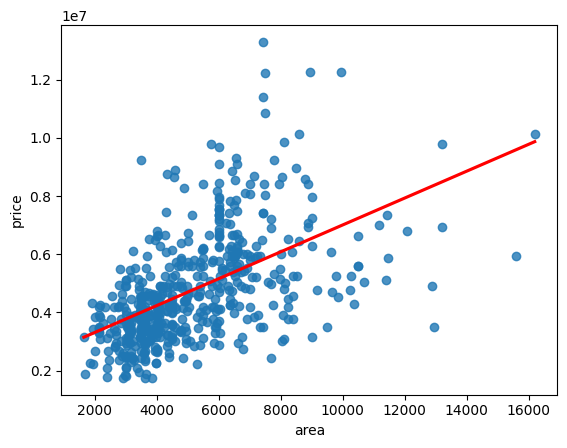

In [730]:
sns.regplot(data=df, x='area', y='price', ci=None, line_kws={"color": "r"})

**Вывод:** ценв растет с увеличением площади

<Axes: xlabel='bathrooms', ylabel='price'>

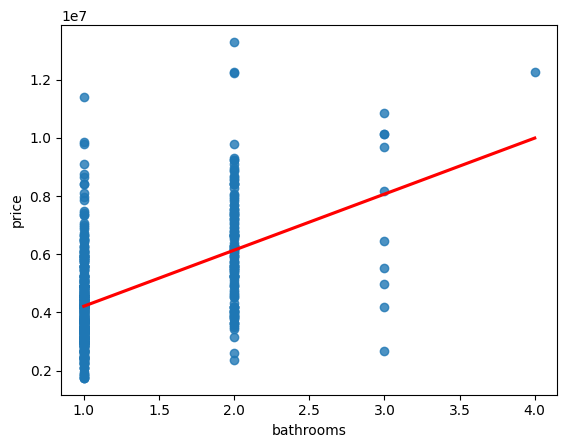

In [731]:
sns.regplot(data=df, x='bathrooms', y='price', ci=None, line_kws={"color": "r"})

**Вывод:** цена растет с увеличением сан-узлов

<Axes: xlabel='bedrooms', ylabel='price'>

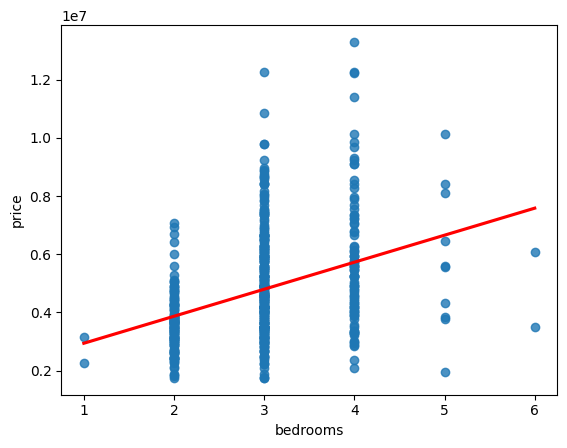

In [732]:
sns.regplot(data=df, x='bedrooms', y='price', ci=None, line_kws={"color": "r"})

**Вывод:** цена растет с увеличением кол-ва спален

<Axes: xlabel='parking', ylabel='price'>

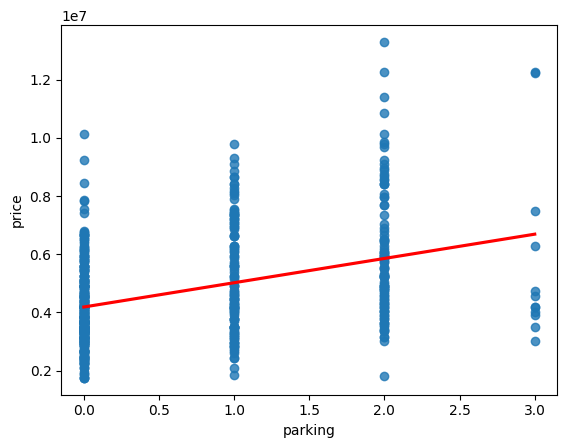

In [733]:
sns.regplot(data=df, x='parking', y='price', ci=None, line_kws={"color": "r"})

**Вывод:** цена растет с увеличением парковочных мест

###  Подгонка модели и спецификация

За целевую переменную берем log(price) чтобы числовие признаки не так сильно расходились между собой

In [734]:
# специфицируем модель через формулу
mod = smf.ols(formula='np.log(price)~area+bedrooms+bathrooms+stories+mainroad+guestroom+basement+hotwaterheating+airconditioning+parking+prefarea++furnished+semi+unfurnished', data=df).fit()
# Коэфициенты модели с округление
mod.params.round(2)

Intercept          10.74
area                0.00
bedrooms            0.03
bathrooms           0.16
stories             0.09
mainroad            0.12
guestroom           0.07
basement            0.09
hotwaterheating     0.16
airconditioning     0.17
parking             0.04
prefarea            0.13
furnished           3.61
semi                3.63
unfurnished         3.50
dtype: float64

Спецификация:
    
$log(price)=\beta_0+\beta_1area+\beta_2bedrooms+\beta_3bathrooms+\beta_4stories+\beta_5mainroad+\beta_6guestroom+\beta_7basement+\beta_8hotwaterheating+\beta_9airconditioning+\beta_{10}parking+\beta_{11}prefarea+\beta_{12}furnished+\beta_{13}semi+\beta_{14}unfurnished+u$

Интерпретация:
1) С добавлением одного сан-узла цена дома увеличивается в среднем на 0.16%
2) Незаконченночть ремонта уменьшает стоимость в среднем на 3.50%
3) Наличия кондиционирования увеличивает стоимость в среднем на 0.17%

###  Вычислим коэффиценты детерминации

In [735]:
# R^2
R2 = mod.rsquared.round(2)
# adj R^2
R2_adj = mod.rsquared_adj.round(2)
print("R^2 =", R2)
print("R^2_adj =", R2_adj)

R^2 = 0.7
R^2_adj = 0.69


**Вывод:** целевая переменная неплохо описывается предикторными

###  TSS ESS RSS

In [736]:
TSS = mod.centered_tss
ESS = mod.ess
RSS = mod.ssr
print("TSS =", TSS.round(3))
print("ESS =", ESS.round(3))
print("RSS =", RSS.round(3))

TSS = 75.348
ESS = 52.665
RSS = 22.682


###  Предсказанное значение и остаток для нескольких наблюдений

In [737]:
ind = np.arange(100, 110)
data = pd.DataFrame({'i': ind, 'Факт': df["price"][ind], 'Fitted': np.exp(mod.predict()[ind]), 'Остаток': df["price"][ind] - np.exp(mod.predict()[ind])})
data

,i,Факт,Fitted,Остаток
100,100,6230000,5.852577e+06,3.774235e+05
101,101,6230000,4.527431e+06,1.702569e+06
102,102,6195000,7.457509e+06,-1.262509e+06
103,103,6195000,6.675302e+06,-4.803017e+05
104,104,6195000,6.091452e+06,1.035476e+05
105,105,6160000,4.730738e+06,1.429262e+06
106,106,6160000,6.470969e+06,-3.109685e+05
107,107,6125000,4.954147e+06,1.170853e+06
108,108,6107500,4.174167e+06,1.933333e+06
109,109,6090000,6.700806e+06,-6.108058e+05


###  Cтандартная ошибка регрессии

In [738]:
n = len(df["price"])
k = 15
s = np.sqrt(RSS / (n - k - 1))
print("s =", s.round(4))

s = 0.2071


###  Значимсть коэффицентов регрессии

In [739]:
table = mod.summary().tables[1]
df_t = pd.read_html(table.as_html(), header=0, index_col=0)[0] # Эту строку запоминать не нужно
df_t

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.741300,0.035000,306.466,0.000,10.67200,10.810000
area,0.000049,0.000005,10.528,0.000,0.00004,0.000059
bedrooms,0.029500,0.014000,2.098,0.036,0.00200,0.057000
bathrooms,0.163200,0.020000,8.159,0.000,0.12400,0.203000
stories,0.090100,0.012000,7.258,0.000,0.06600,0.115000
mainroad,0.117500,0.028000,4.268,0.000,0.06300,0.172000
guestroom,0.069800,0.025000,2.738,0.006,0.02000,0.120000
basement,0.089300,0.021000,4.185,0.000,0.04700,0.131000
hotwaterheating,0.163400,0.043000,3.784,0.000,0.07900,0.248000
airconditioning,0.174800,0.021000,8.336,0.000,0.13400,0.216000


Вычислим критическое значение для t-теста c уровнем значимости 10%.

In [740]:
alpha = 0.1 # уровень значимости
print('Уровень значимости alpha: ', alpha)
DF = int(mod.df_resid) # число степеней свободы 
t_crit = scipy.stats.t.ppf(1-alpha/2, DF)
print('Критическое значение t_crit: ', t_crit.round(3))

Уровень значимости alpha:  0.1
Критическое значение t_crit:  1.648


In [741]:
df_t['znachimosty'] = df_t.apply(lambda x : 'znachim' if np.abs(x['t']) > t_crit else 'ne znachim', axis = 1 )
df_t

,coef,std err,t,P>|t|,[0.025,0.975],znachimosty
Intercept,10.741300,0.035000,306.466,0.000,10.67200,10.810000,znachim
area,0.000049,0.000005,10.528,0.000,0.00004,0.000059,znachim
bedrooms,0.029500,0.014000,2.098,0.036,0.00200,0.057000,znachim
bathrooms,0.163200,0.020000,8.159,0.000,0.12400,0.203000,znachim
stories,0.090100,0.012000,7.258,0.000,0.06600,0.115000,znachim
mainroad,0.117500,0.028000,4.268,0.000,0.06300,0.172000,znachim
guestroom,0.069800,0.025000,2.738,0.006,0.02000,0.120000,znachim
basement,0.089300,0.021000,4.185,0.000,0.04700,0.131000,znachim
hotwaterheating,0.163400,0.043000,3.784,0.000,0.07900,0.248000,znachim
airconditioning,0.174800,0.021000,8.336,0.000,0.13400,0.216000,znachim


Построим 95% довирительные интервалы для каждого коэффицента

In [742]:
mod.conf_int(alpha=0.05)

,0,1
Intercept,10.672447,10.810150
area,0.000040,0.000059
bedrooms,0.001871,0.057072
bathrooms,0.123908,0.202501
stories,0.065736,0.114527
mainroad,0.063402,0.171544
guestroom,0.019716,0.119863
basement,0.047385,0.131241
hotwaterheating,0.078586,0.248263
airconditioning,0.133613,0.216002


### Значимость регрессии

In [743]:
# Результаты F-теста на значимость регрессии (тестовая статистика и P-значение)
mod.fvalue.round(3), mod.f_pvalue

(94.839, 4.204281734776599e-129)

In [744]:
# 5%-критическое значение F-распределения
f.ppf(q=1-0.05, dfn=mod.df_model, dfd=mod.df_resid).round(3)

1.739

**Вывод: ререссия значима**

###  Cовместная значимость bedrooms, bathrooms и  stories т.е. гипотеза $H_0:\beta_{bedrooms}=\beta_{bathrooms}=\beta_{stories}=0$

In [745]:
print(mod.f_test('bedrooms=stories=bathrooms=0'))

<F test: F=74.68745658182861, p=2.5784942836523564e-40, df_denom=531, df_num=3>


In [746]:
f.ppf(q=1-0.05, dfn=3, dfd=mod.df_resid)

2.621690060147453

**Вывод: коэффиценты совместно значимы**

###  Протестируем гипотезу о линейных ограничениях $H_0:\beta_{area}+\beta_{guestroom}+\beta_{stories}=0.1$

In [747]:
print(mod.f_test('area+guestroom+stories=0'))

<F test: F=33.37628208955597, p=1.2948739861668714e-08, df_denom=531, df_num=1>


In [748]:
# критическое значение
f.ppf(q=1-0.05, dfn=1, dfd=mod.df_resid)

3.8590306661560283

Вывод: гипотеза отвергается

###  Стрктурные сдвиги

Рассмотрим нашу регресси отдельно для домов с отоплением $(\beta)$  и без $(\gamma)$

Будем тестировать $H_0:\beta_j=\gamma_j$

Уровеь значимости 1%

In [749]:
specification = 'np.log(price)~area+bedrooms+bathrooms+stories+mainroad+guestroom+basement+hotwaterheating+airconditioning+parking+prefarea++furnished+semi+unfurnished'
# подгонка по полному датасету
mod_overall = smf.ols(formula=specification, data=df).fit()
# подгонка только по М
mod_heat_only = smf.ols(formula=specification, data=df[df['hotwaterheating']==1]).fit()
# подгонка только по Ж
mod_notheat_only = smf.ols(formula=specification, data=df[df['hotwaterheating']==0 ]).fit()
# Вывод трёх регрессий в одной таблице
summary_col(results=[mod_heat_only, mod_notheat_only, mod_overall], stars=True, model_names=['heat', 'notheat', 'Общая'],
           info_dict={'N': lambda x: x.nobs, 'F-stat': lambda x: x.fvalue})

,heat,notheat,Общая
Intercept,6.0260***,10.7617***,10.7413***
,(0.1074),(0.0356),(0.0350)
area,0.0000,0.0000***,0.0000***
,(0.0000),(0.0000),(0.0000)
bedrooms,0.2635***,0.0226,0.0295**
,(0.0856),(0.0142),(0.0141)
bathrooms,0.0224,0.1620***,0.1632***
,(0.1328),(0.0202),(0.0200)
stories,-0.0238,0.0917***,0.0901***
,(0.1024),(0.0124),(0.0124)


In [750]:
# Ингредиенты тестовой статистики
print('RSS (overall)=', mod_overall.ssr)
print('RSS (heat_only)=', mod_heat_only.ssr)
print('RSS (notheat_only)=', mod_notheat_only.ssr)
print('n=', mod_overall.nobs)
print('k=', mod_overall.df_model)

RSS (overall)= 22.682382639979227
RSS (heat_only)= 0.4862907148201128
RSS (notheat_only)= 21.049319422880725
n= 545.0
k= 13.0


In [751]:
F = (mod_overall.ssr-mod_heat_only.ssr-mod_notheat_only.ssr)/(mod_heat_only.ssr+mod_notheat_only.ssr)*(mod_overall.nobs-2*(mod_overall.df_model+1))/(mod_overall.df_model+1)
F_cr = f.ppf(q=1-0.01, dfn=mod_overall.df_model+1, dfd=mod_overall.nobs-2*(mod_overall.df_model+1))
F.round(3), F_cr.round(3)

(1.966, 2.116)

**Вывод: струтурные сдвиги незначимы**

Грифики

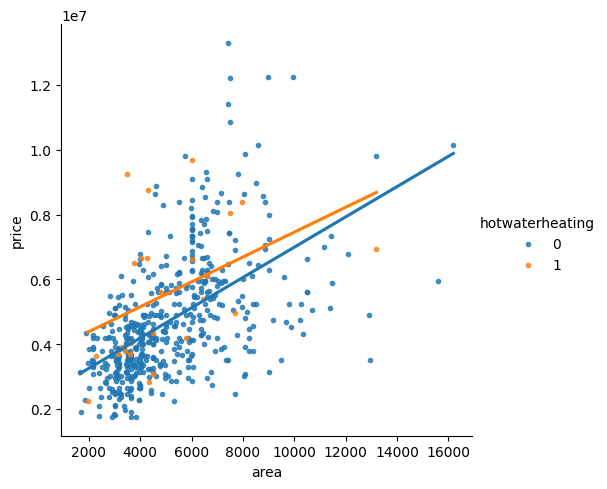

In [752]:
sns.lmplot(data=df, x='area', y='price', hue='hotwaterheating', ci=False, markers='.')

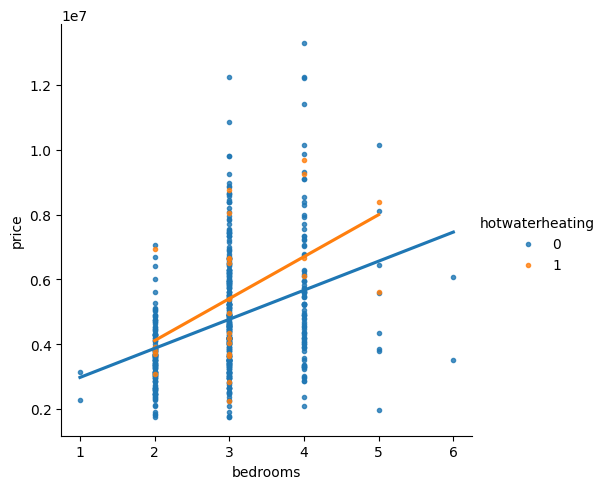

In [753]:
sns.lmplot(data=df, x='bedrooms', y='price', hue='hotwaterheating', ci=False, markers='.')

###  Прогнозирование для модели регрессии

Рассморим 10 человек

In [754]:
new_df = df.sample(7)
new_df = new_df.drop(labels={'furnishingstatus', 'price'}, axis=1)
new_df

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi,unfurnished
440,3640,4,1,2,1,0,1,0,0,0,0,0,0,1
176,8520,3,1,1,1,0,0,0,1,2,0,1,0,0
458,3850,3,1,2,1,0,0,0,0,0,0,0,0,1
164,6710,3,2,2,1,1,1,0,0,1,1,1,0,0
57,9000,4,2,4,1,1,0,0,1,1,1,1,0,0
15,6000,4,1,2,1,0,1,0,0,2,0,0,1,0
114,6800,2,1,1,1,1,1,0,0,2,0,1,0,0


In [755]:
np.exp(mod.predict(exog=new_df, transform=True))

440    3.579541e+06
176    5.376806e+06
458    3.211837e+06
164    6.767471e+06
57     1.018267e+07
15     5.000106e+06
114    4.719939e+06
dtype: float64

Непосредственное вычисление $\hat{\beta}_0+\hat{\beta}_1x_1+\cdots+\hat{\beta}_kx_k$ для каждого наблюдения.

В матричном виде $X\hat{\beta}$, где $X$ состоит из значений переменных по столбцам + первый столбец из единиц для учёта $\beta_0$

###  Мультиколлинеарность

Какие регрессии нужно рассматривать для вычисления показателей VIF для коэффициентов hotwaterheating, airconditioning, mainroad?


Ответ:


**hotwaterheating~area+bedrooms+bathrooms+stories+mainroad+guestroom+basement+airconditioning+parking+prefarea++furnished+semi+unfurnished**


**airconditioning~area+bedrooms+bathrooms+stories+mainroad+guestroom+basement+hotwaterheating+parking+prefarea++furnished+semi+unfurnished**


**mainroad~area+bedrooms+bathrooms+stories+parking+guestroom+basement+hotwaterheating+airconditioning+parking+prefarea++furnished+semi+unfurnished**

In [756]:
mod1 = smf.ols(formula='hotwaterheating~area+bedrooms+bathrooms+stories+mainroad+guestroom+basement+airconditioning+parking+prefarea++furnished+semi+unfurnished', data=df).fit()
mod2 = smf.ols(formula='airconditioning~area+bedrooms+bathrooms+stories+mainroad+guestroom+basement+hotwaterheating+parking+prefarea++furnished+semi+unfurnished', data=df).fit()
mod3 = smf.ols(formula='mainroad~area+bedrooms+bathrooms+stories+parking+guestroom+basement+hotwaterheating+airconditioning+parking+prefarea++furnished+semi+unfurnished', data=df).fit()
#Результаты подгонки
# info_dict = {'No. Observations': lambda x: '{0:d}'.format(int(x.nobs)), 
#              'R-squared': lambda x: "%#8.3f" % x.rsquared,
#              'Adj. R-squared': lambda x: "%#8.3f" % x.rsquared_adj,
#              'Residual Std. Error': lambda x: "%#8.3f" % x.mse_resid**0.5,
#              'F-statistic': lambda x: '{:.3f}'.format(x.fvalue), 
#              'Prob (F-statistic)': lambda x: '{:.3f}'.format(x.f_pvalue)
#              }

print(summary_col([mod1, mod2, mod3], stars=True, float_format='%.3f'))


                hotwaterheating airconditioning  mainroad
---------------------------------------------------------
Intercept       0.001           -0.121*         0.547*** 
                (0.035)         (0.072)         (0.050)  
R-squared       0.040           0.175           0.147    
R-squared Adj.  0.018           0.156           0.128    
airconditioning -0.073***                       -0.009   
                (0.021)                         (0.033)  
area            -0.000          0.000***        0.000*** 
                (0.000)         (0.000)         (0.000)  
basement        0.006           0.040           0.017    
                (0.021)         (0.044)         (0.034)  
bathrooms       0.026           0.045           -0.033   
                (0.020)         (0.041)         (0.031)  
bedrooms        0.006           -0.007          -0.063***
                (0.014)         (0.029)         (0.022)  
furnished       0.002           0.022           0.220*** 
             

In [757]:
VIF_1 = 1/(1 - mod1.rsquared)
VIF_1.round(2)

1.04

In [758]:
VIF_2 = 1/(1 - mod2.rsquared)
VIF_2.round(2)

1.21

In [759]:
VIF_1 = 1/(1 - mod3.rsquared)
VIF_1.round(2)

1.17

Корреляции между регрессорами

In [760]:
summary_params(mod)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,10.741298,0.035049,306.466449,0.000000e+00,10.672447,10.810150
area,0.000049,0.000005,10.528162,1.140566e-23,0.000040,0.000059
bedrooms,0.029472,0.014050,2.097613,3.641145e-02,0.001871,0.057072
bathrooms,0.163204,0.020004,8.158653,2.466559e-15,0.123908,0.202501
stories,0.090131,0.012419,7.257701,1.405848e-12,0.065736,0.114527
mainroad,0.117473,0.027525,4.267876,2.337385e-05,0.063402,0.171544
guestroom,0.069789,0.025490,2.737902,6.390736e-03,0.019716,0.119863
basement,0.089313,0.021343,4.184542,3.343698e-05,0.047385,0.131241
hotwaterheating,0.163424,0.043187,3.784095,1.718359e-04,0.078586,0.248263
airconditioning,0.174807,0.020970,8.336052,6.619422e-16,0.133613,0.216002


In [761]:
# Матрицы регрессионного дизайна
y, X = patsy.dmatrices(specification, df, return_type='dataframe')
X.head()

,Intercept,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi,unfurnished
0,1.0,7420.0,4.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0
1,1.0,8960.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0
2,1.0,9960.0,3.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
3,1.0,7500.0,4.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0
4,1.0,7420.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0


In [762]:
# Удалим первый столбец с единицами
# X.drop(labels='Intercept', axis=1)
# Корреляционная матрицы для регрессоров
X.drop(labels='Intercept', axis=1).corr().round(3)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi,unfurnished
area,1.000,0.152,0.194,0.084,0.289,0.140,0.047,-0.009,0.222,0.353,0.235,0.146,0.006,-0.142
bedrooms,0.152,1.000,0.374,0.409,-0.012,0.081,0.097,0.046,0.161,0.139,0.079,0.079,0.050,-0.126
bathrooms,0.194,0.374,1.000,0.326,0.042,0.126,0.102,0.067,0.187,0.177,0.063,0.108,0.030,-0.132
stories,0.084,0.409,0.326,1.000,0.122,0.044,-0.172,0.019,0.294,0.046,0.044,0.093,-0.004,-0.083
mainroad,0.289,-0.012,0.042,0.122,1.000,0.092,0.044,-0.012,0.105,0.204,0.200,0.130,0.011,-0.133
guestroom,0.140,0.081,0.126,0.044,0.092,1.000,0.372,-0.010,0.138,0.037,0.161,0.100,0.006,-0.099
basement,0.047,0.097,0.102,-0.172,0.044,0.372,1.000,0.004,0.047,0.051,0.228,0.070,0.050,-0.118
hotwaterheating,-0.009,0.046,0.067,0.019,-0.012,-0.010,0.004,1.000,-0.130,0.068,-0.059,-0.008,0.064,-0.059
airconditioning,0.222,0.161,0.187,0.294,0.105,0.138,0.047,-0.130,1.000,0.159,0.117,0.161,-0.053,-0.094
parking,0.353,0.139,0.177,0.046,0.204,0.037,0.051,0.068,0.159,1.000,0.092,0.131,0.041,-0.166


<Axes: >

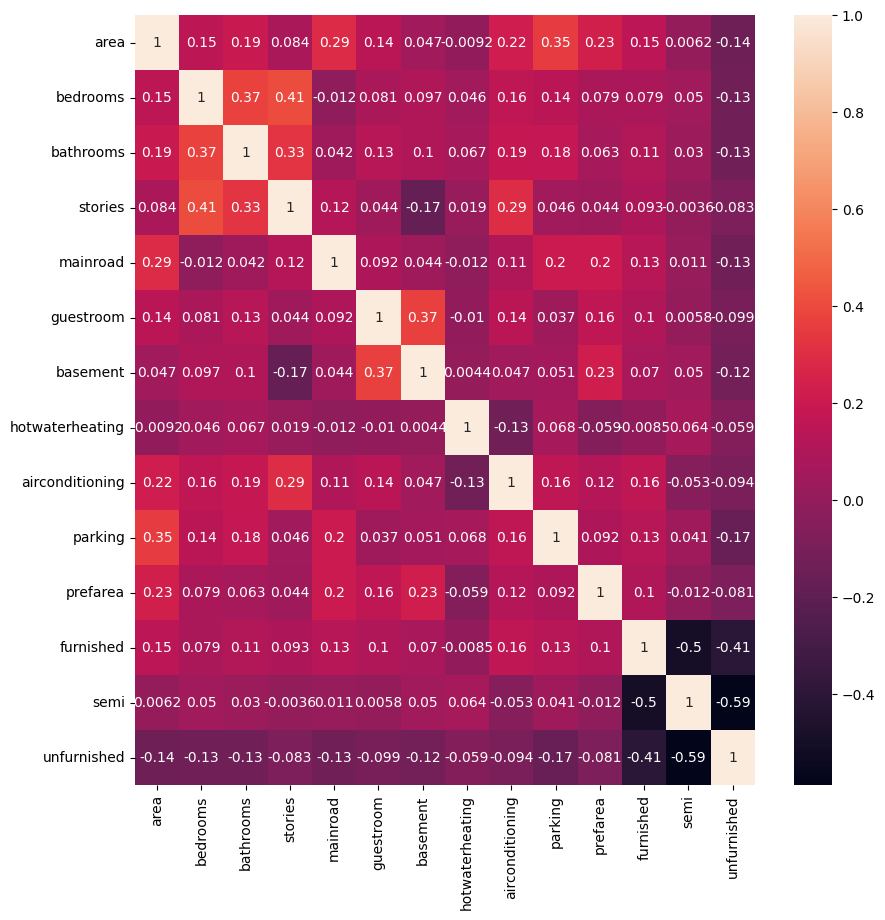

In [763]:
# Визуализация корреляционной матрицы
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.heatmap(X.drop(labels='Intercept', axis=1).corr(), annot=True)

**Вывод:**
1) обратная корелляция между значениями категориального признака
2) корелляция между parking и area (у больших площадей больше парквочных мест)
3) логичная корелляция между basement и guestroom
4) логичная корелляция между bedrooms и bathrooms

### 15. Тесты на спецификацию

RESET-тест (неробастный!) со степенями главных компонент (до 4й)

Гипотеза: $H_0:\beta_{price^2}=\beta_{price^3}=\beta_{price^4}=0$

In [764]:
linear_reset(mod, power=4, test_type='princomp', use_f=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.34121523708486795, p=0.7955363357376534, df_denom=528, df_num=3>

In [765]:
alpha = 0.05
F_cr = stats.f.ppf(1-0.05,5,len(df)-18)
F_cr.round(2)

2.23

**Вывод: Гипотеза не отвергается, регрессия согласуется с данными**

###  Диагностические тесты на гетероскедастичность
**Выбререм уровень значимости 1%**

Для тестрования нужна матрица наблюдений регрессоров модели. Её можно получить как `mod.model.exog`

**BP-тест** 

Модель гетероскедастичности $Var(u_i|X)=f(\gamma_0+\gamma_1x_1+\cdots+\gamma_kx_k)$

Тестируем $H_0:\begin{pmatrix} \gamma_1 & \cdots & \gamma_k \end{pmatrix}=0$ vs $H_1:\begin{pmatrix} \gamma_1 & \cdots & \gamma_k \end{pmatrix}\ne 0$

*Нулевая гипотеза*: гомоскедаастичность ошибки

*Альтернатива*: гетероскедастиность ошибки

*Промежуточная регрессия*: $e^2$ на регрессоры модели

In [766]:
BP_stat, p_val, F_stat, p_val_F = sms.het_breuschpagan(resid=mod.resid, exog_het=mod.model.exog)
BP_stat, p_val

(29.837854752098, 0.008033935521068592)

1%-критическое значение распределения $\chi^2_{df}$

In [767]:
chi2.ppf(q=1-0.01, df=mod.df_model)

27.68824961045705

**Вывод**: тест указывает на гетероскедастиность (тестируемая гипотеза не принимается)

**White-тест** (общий случай)

Тестируем $H_0:Var(u_i|X)=\sigma^2$ vs $H_1:Var(u_i|X)=\sigma^2_i$

*Нулевая гипотеза*: гомоскедастичность ошибки

*Альтернатива*: гетероскедастиность ошибки (общего вида)

*Промежуточная регрессия*: $e^2$ на регрессоры модели, их квадраты и попарные произведения

In [768]:
test_stat, p_val, F_stat, pval_f = sms.het_white(resid=mod.resid, exog=mod.model.exog)
test_stat, p_val

(152.6918497555044, 0.00016072001678957908)

**Вывод**: тест указывает на гетероскедастиность (тестируемая гипотеза принимается) .т.к. $p\_val<\alpha$

### 17. Робастный test

Подгоним модель с поправкою на гетероскедастичность (робастная HC3-оценка ковариационной матрицы)

In [769]:
mod_hc=smf.ols(formula=specification, data=df).fit(cov_type='HC3')
mod_hc.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.692
No. Observations:                 545   F-statistic:                 2.350e+05
Covariance Type:                  HC3   Prob (F-statistic):               0.00
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.7413      0.034    318.464      0.000      10.675      10.807
area             4.949e-05   4.92e-06     10.050      0.000    3.98e-05    5.91e-05
bedrooms            0.0295      0.014      2.074      0.038       0.002       0.057
bathrooms           0.1632      0.022      7.511      0.000       0.121       0.206
stories             0.0901      0.012      7.585      0.000       0.067       0.113
mainroad            0.1175      0.027      4.309      0.000       0.064       0.171
guestroom           0.0698      0.026      2.687      0.007       0.019       0.121
basement            0.0893      0.024      3.767      0.000       0.043       0.136
hotwaterheating     0.1634      0.055      2.956      0.003       0.055       0.272
airconditioning     0.1748      0.021      8.317      0.000       0.134       0.216
parking             0.0448      0.012      3.824      0.000       0.022       0.068
prefarea            0.1268      0.022      5.751      0.000       0.084       0.170
furnished           3.6111      0.019    186.940      0.000       3.573       3.649
semi                3.6291      0.016    221.351      0.000       3.597       3.661
unfurnished         3.5012      0.017    211.954      0.000       3.469       3.534
===================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 3.69e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Сравним результаты и исходной оценкой модели

In [770]:
summary_col(results=[mod, mod_hc], stars=True, model_names=['OLS-s.e.', 'HC3-s.e.'])

,OLS-s.e.,HC3-s.e.
Intercept,10.7413***,10.7413***
,(0.0350),(0.0337)
area,0.0000***,0.0000***
,(0.0000),(0.0000)
bedrooms,0.0295**,0.0295**
,(0.0141),(0.0142)
bathrooms,0.1632***,0.1632***
,(0.0200),(0.0217)
stories,0.0901***,0.0901***
,(0.0124),(0.0119)


**Вывод:** Неробастная и робастная тестовая статистики почти совпадают, следовательно влияние ошибок моделирования на характеристики регрессионной модели незначимо.

##  Вывод: 
1) Проведен анализ датасета недвижемости '12housing' с целевой пременной price
2) Данные были правильно преобразованы и приведены в удобный для исследования вид
3) Использовалась визуализация даных для лучшего понимания внутреннего строения зависимостей и наглядности выводов
4) В ходе работы удалось достичь достаточно высокой точнисти предсказания целевой переменной
5) Проверено множество гипотез как о коэффицентах так и о модели в целом
6) Модель исследована на наличие корелляций и зависимотей
7) Все шаги анализа подкреплены логичными выводами